In [1]:
import os
import zipfile

# Make a kaggle folder and move the json file there
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Give the API key file proper permissions
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d karakaggle/kaggle-cat-vs-dog-dataset

Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
License(s): unknown
 99% 780M/787M [00:06<00:00, 216MB/s]
100% 787M/787M [00:08<00:00, 100MB/s]


In [3]:
# Unzip the dataset
import zipfile
with zipfile.ZipFile("kaggle-cat-vs-dog-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("cat_vs_dog")

In [18]:
# LIBRIES
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# LOAD DATA

In [5]:
train_data_gen = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.2
)

In [7]:
train_gen = train_data_gen.flow_from_directory(
    '/content/cat_vs_dog/datasets/imgs',
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training'

)

val_gen = train_data_gen.flow_from_directory(
    '/content/cat_vs_dog/datasets/imgs',
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation'

)

Found 19968 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.


In [8]:
import numpy as np

unique, counts = np.unique(train_gen.classes, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique_val, counts_val = np.unique(val_gen.classes, return_counts=True)
print("Validation class distribution:", dict(zip(unique_val, counts_val)))

Train class distribution: {np.int32(0): np.int64(9992), np.int32(1): np.int64(9976)}
Validation class distribution: {np.int32(0): np.int64(2498), np.int32(1): np.int64(2493)}


In [9]:
# One batch of training data
train_images, train_labels = next(train_gen)

# One batch of validation data
val_images, val_labels = next(val_gen)

In [10]:
import matplotlib.pyplot as plt

def show_images(images, labels, title, class_names=["Cat", "Dog"]):
    plt.figure(figsize=(12, 6))
    for i in range(8):  # show first 8 images
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])
        label = class_names[int(labels[i])]
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

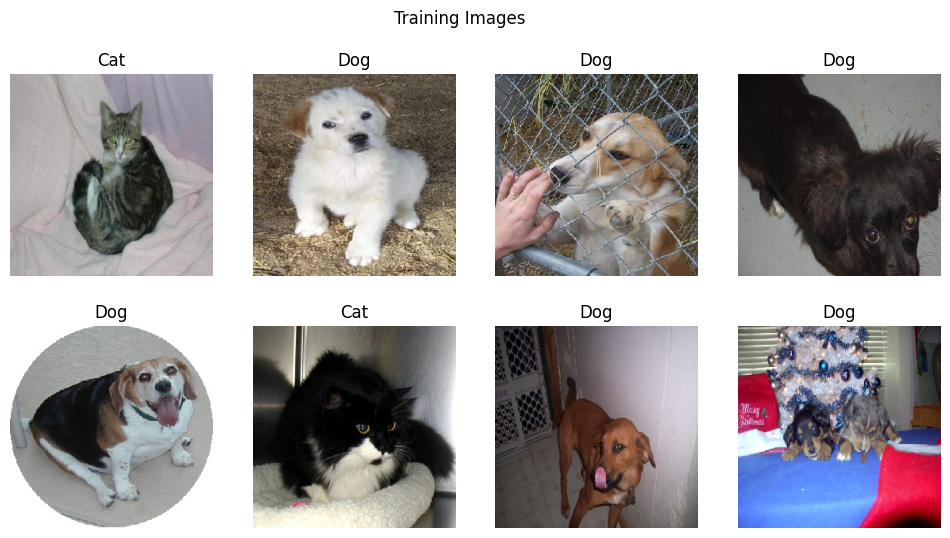

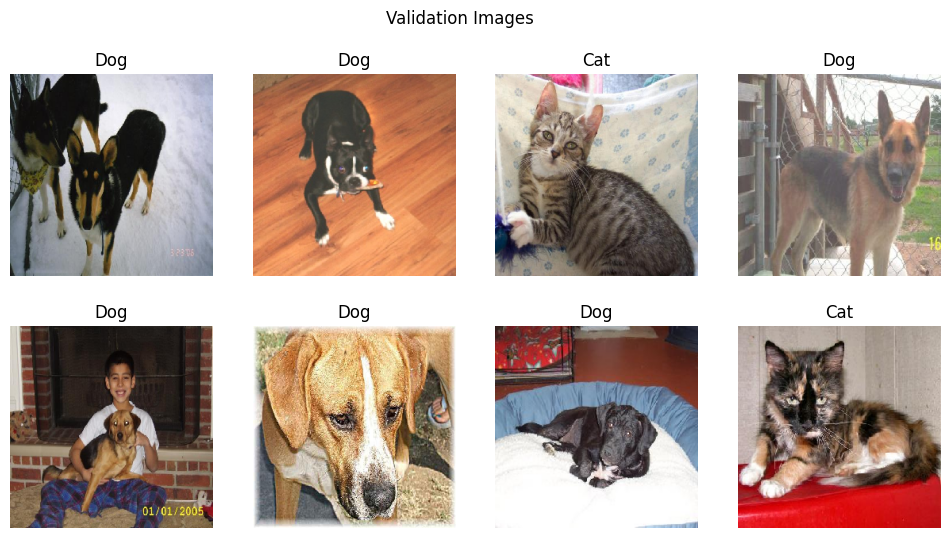

In [11]:
show_images(train_images, train_labels, title="Training Images")
show_images(val_images, val_labels, title="Validation Images")

# BUILD CNN MODEL

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping

In [26]:
model = Sequential()

# CONV1
model.add(Conv2D(32,kernel_size=(3,3),strides=(2,2),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV2
model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# CONV3
model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# FLATTEN
model.add(GlobalAveragePooling2D())

# FULLY CONNECTED LAYERS
model.add(Dense(128,activation='selu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(0.01)))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 127, 127, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,977 (464.75 KB)

 Trainable params: 118,529 (463.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [28]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [29]:
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.001,
    patience = 5,
    mode='auto',
    restore_best_weights=True
)

In [30]:
history = model.fit(train_gen,epochs=30,validation_data=val_gen,callbacks=early_stop)

Epoch 1/30
230/624 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5722 - loss: 1.9656

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 64s 94ms/step - accuracy: 0.6010 - loss: 1.6617 - val_accuracy: 0.7099 - val_loss: 0.7708
Epoch 2/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.7174 - loss: 0.6858 - val_accuracy: 0.7341 - val_loss: 0.5630
Epoch 3/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.7609 - loss: 0.5225 - val_accuracy: 0.6353 - val_loss: 0.6980
Epoch 4/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.7904 - loss: 0.4744 - val_accuracy: 0.7207 - val_loss: 0.6440
Epoch 5/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.8133 - loss: 0.4321 - val_accuracy: 0.7528 - val_loss: 0.5900
Epoch 6/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.8438 - loss: 0.3847 - val_accuracy: 0.7882 - val_loss: 0.4693
Epoch 7/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.8623 - loss: 0.3402 - val_accuracy: 0.7473 - val_loss: 0.5680
Epoch 8/30
624/624 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.8797 - loss: 0.3055 - val_accurac

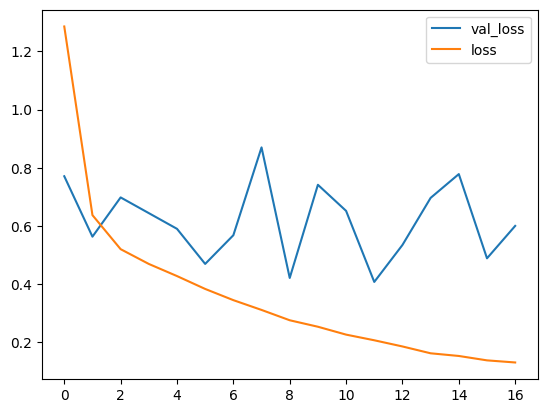

In [31]:
plt.plot(history.history['val_loss'],label='val_loss')
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.show()

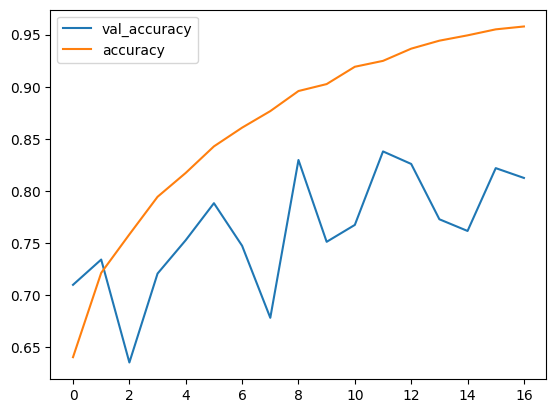

In [32]:
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.plot(history.history['accuracy'],label='accuracy')
plt.legend()
plt.show()

# TEST THE MODEL

In [33]:
from tensorflow.keras.preprocessing import image

### PREDICTION FOR CAT

In [67]:
img = image.load_img('catimg.png',target_size=(256,256))

In [68]:
img_arr = image.img_to_array(img)
img_arr = img_arr/256
img_arr = np.expand_dims(img_arr, axis=0)


In [69]:
prediction = model.predict(img_arr)
if prediction[0][0] > 0.5:
    print(f"This is a Dog\nProbability : {prediction[0][0]}")
else:
    print(f"This is a Cat\nProbability : {1-prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This is a Cat
Probability : 0.6991045475006104


### PREDICTION FOR DOG

In [70]:
img = image.load_img('dogimg.png',target_size=(256,256))

In [71]:
img_arr = image.img_to_array(img)
img_arr = img_arr/256
img_arr = np.expand_dims(img_arr, axis=0)

In [72]:
prediction = model.predict(img_arr)
if prediction[0][0] > 0.5:
    print(f"This is a Dog\nProbability : {prediction[0][0]}")
else:
    print(f"This is a Cat\nProbability : {1-prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
This is a Dog
Probability : 0.9852525591850281


## PREDICTING 5 DOGS

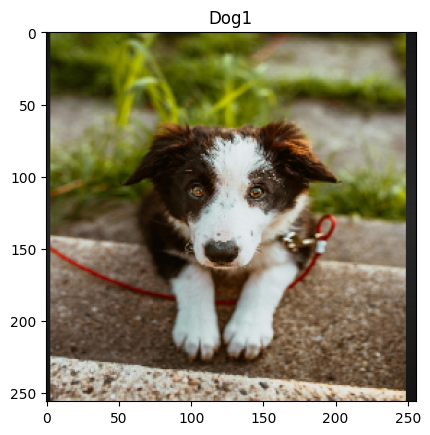

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This is a Dog
Probability : 0.8689661026000977


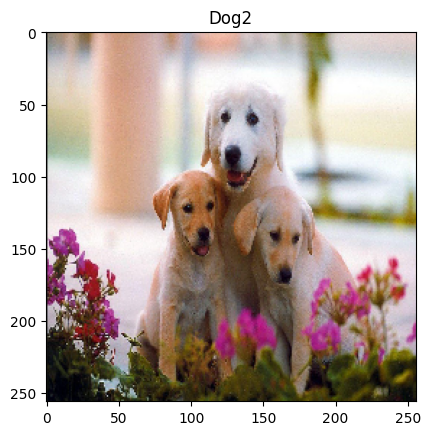

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This is a Dog
Probability : 0.7591081857681274


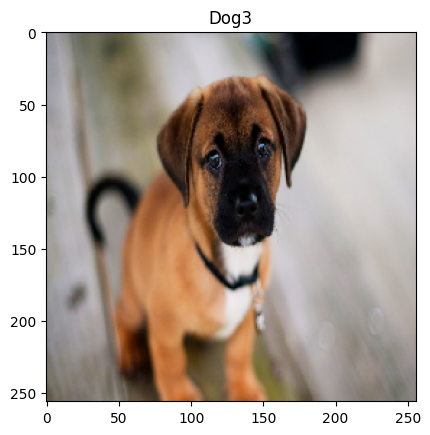

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This is a Cat
Probability : 0.8933843970298767


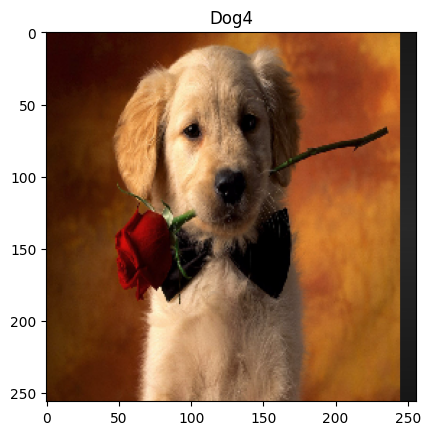

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This is a Dog
Probability : 0.8690962195396423


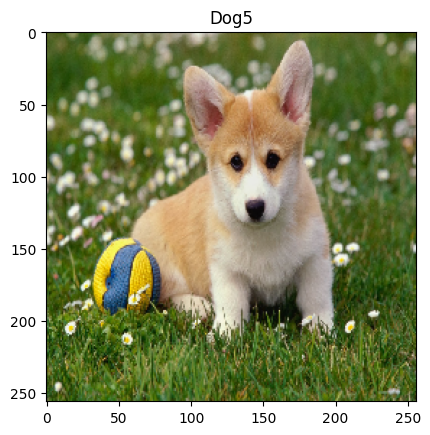

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
This is a Dog
Probability : 0.9761354327201843


In [80]:
for i in range(1,6):
  img = image.load_img(f"dog{i}.png",target_size=(256,256))
  plt.imshow(img)
  plt.title(f"Dog{i}")
  plt.show()
  img_arr = image.img_to_array(img)
  img_arr = img_arr/256
  img_arr = np.expand_dims(img_arr, axis=0)
  prediction = model.predict(img_arr)
  if prediction[0][0] > 0.5:
      print(f"This is a Dog\nProbability : {prediction[0][0]}")
  else:
      print(f"This is a Cat\nProbability : {1-prediction[0][0]}")

# PREDICTING 5 CATS

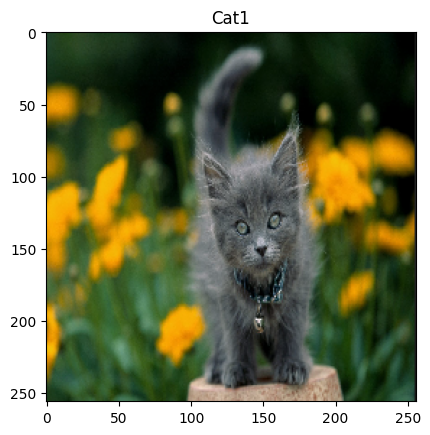

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
This is a Cat
Probability : 0.9714820384979248


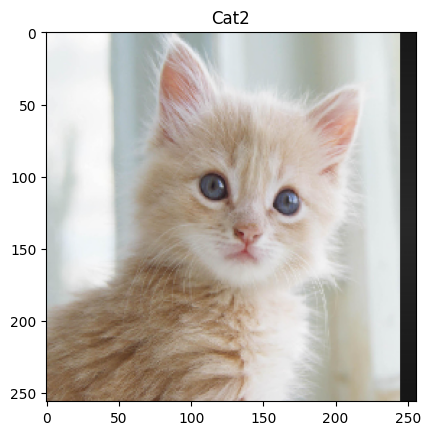

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This is a Cat
Probability : 0.6485617756843567


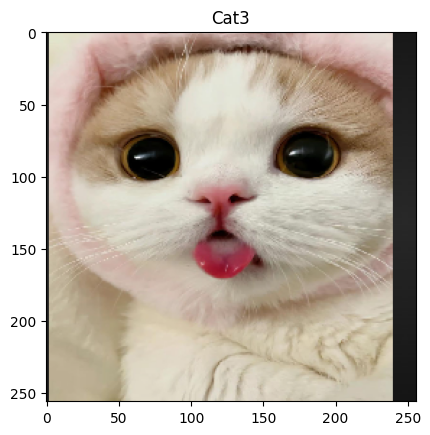

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This is a Cat
Probability : 0.9774725437164307


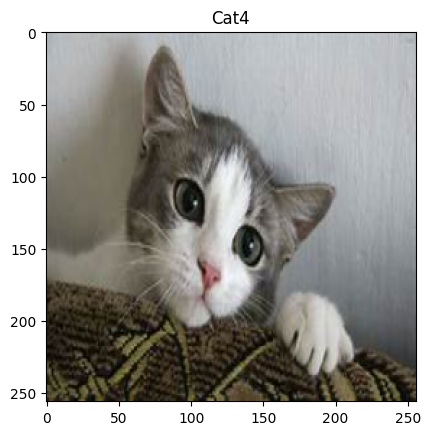

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This is a Dog
Probability : 0.9231088757514954


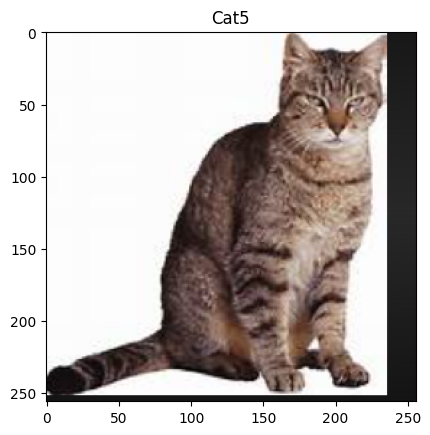

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
This is a Cat
Probability : 0.9869217872619629


In [81]:
for i in range(1,6):
  img = image.load_img(f"cat{i}.png",target_size=(256,256))
  plt.imshow(img)
  plt.title(f"Cat{i}")
  plt.show()
  img_arr = image.img_to_array(img)
  img_arr = img_arr/256
  img_arr = np.expand_dims(img_arr, axis=0)
  prediction = model.predict(img_arr)
  if prediction[0][0] > 0.5:
      print(f"This is a Dog\nProbability : {prediction[0][0]}")
  else:
      print(f"This is a Cat\nProbability : {1-prediction[0][0]}")